In [1]:
import numpy as np
import os
import pickle

# IMPORTO I DATI PER VOTTIGNASCO

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy"
v_test_image_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy"
v_test_target_dates_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy"
v_test_images_dates = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy"
v_test_normalization_factors_std_path  = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy"
v_test_normalization_factors_mean_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy"

# Carica l'array numpy dai file
vottignasco_test_OHE         = np.load(v_test_OHE_path)
vottignasco_test_image       = np.load(v_test_image_path)
vottignasco_test_dates       = np.load(v_test_target_dates_path)
vottignasco_test_image_dates = np.load(v_test_images_dates)
vott_target_test_std         = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean        = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

105
105
105


In [2]:
import sys 

# Aggiungi il percorso della cartella XAI (risali di tre livelli dal notebook)
xai_path = os.path.abspath(os.path.join('..', '..', '..'))
sys.path.append(xai_path)

In [3]:
from common import plots

import importlib

# Forza il reload del modulo
importlib.reload(plots)

<module 'common.plots' from '/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/common/plots.py'>

In [4]:
total_auc_insertion_s2_all = []
total_auc_deletion_s2_all  = []

total_auc_insertion_s3_all = []
total_auc_deletion_s3_all  = []

total_auc_insertion_s4_all = []
total_auc_deletion_s4_all  = []

l_values   = [8,12,13,16]
p_values   = [5,6,7,8]
h_w_values = [(2,2), (2,3), (2,4)]

In [ ]:
import matplotlib.pyplot as plt

save = False

for l in l_values:
    for p in p_values:
        for h,w in h_w_values:

            path_to_load_results = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial_temporal/results/01_marc_st_rise_total_setups/rise_st_original_result_setup_l_{l}_h{h}_w{w}_p_0{p}.pkl"
            # Load della lista results
            with open(path_to_load_results, 'rb') as file:
                result = pickle.load(file)
        
            param = result["parameters_comb"]
            #print(param)

            # Percorso dove salvare il plot
            output_dir = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial_temporal/scripts/notebooks/results/results_l{l}"

            for index_i in range(2,5):
                s_i_errors_insertion = result["errors_insertion"][:,index_i-1,:]
                s_i_errors_deletion  = result["errors_deletion"][:,index_i-1,:]

                output_path_ins_del = os.path.join(output_dir, f"{param}_ins_del_S_{index_i}.png")
                auc_insertion_s_i,auc_deletion_s_i = plots.plot_combined_curves(s_i_errors_insertion, s_i_errors_deletion, title=f"Ins/Del Mean Curves S{index_i}_{param}", save=save,
                                                                       save_path=output_path_ins_del)
        
                if (index_i == 2):
                    total_auc_insertion_s2_all.append([auc_insertion_s_i, param])
                    total_auc_deletion_s2_all.append([auc_deletion_s_i, param])
                elif (index_i == 3):
                    total_auc_insertion_s3_all.append([auc_insertion_s_i, param])
                    total_auc_deletion_s3_all.append([auc_deletion_s_i, param])
                else:
                    total_auc_insertion_s4_all.append([auc_insertion_s_i, param])
                    total_auc_deletion_s4_all.append([auc_deletion_s_i, param])

                plt.close()

                if save:
                    print(f"Plot salvato in: {output_path_ins_del}")

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_grouped_auc_with_hw(data, title='AUC Comparison for l and h_w_p combinations'):
    """
    Plotta un grafico comparativo delle AUC raggruppate per l_X,
    con i punti etichettati da h_Y_w_Z_p_K.

    Args:
    - data (list of lists): Ogni elemento è una coppia [AUC, configurazione] (es. 'l_8_h2_w2_p_05')
    - title (str): Titolo del grafico
    """

    # Raggruppa le AUC per ogni l_X
    grouped = defaultdict(list)
    for auc, param in data:
        l_group = param.split('_')[0] + '_' + param.split('_')[1]  # Estrae 'l_X'
        hw_p = '_'.join(param.split('_')[2:])  # Estrae 'h_Y_w_Z_p_K'
        grouped[l_group].append((auc, hw_p))
    
    # Ordina i gruppi l_X in ordine crescente
    grouped = dict(sorted(grouped.items(), key=lambda x: int(x[0].split('_')[1])))

    # Posizioni sull'asse x per i gruppi l_X
    group_positions = list(range(len(grouped)))

    plt.figure(figsize=(12, 6))

    # Plotta i punti per ogni gruppo l_X
    for i, (l_group, values) in enumerate(grouped.items()):
        auc_values = [item[0] for item in values]
        hw_p_labels = [item[1] for item in values]
        
        # Spaziatura orizzontale per i punti all'interno del cluster
        x_positions = [i + (j - len(values) / 2) * 0.1 for j in range(len(values))]

        # Scatter plot
        plt.scatter(x_positions, auc_values, label=l_group)

        # Aggiungi etichette h_Y_w_Z_p_K accanto ai punti
        for x, auc, label in zip(x_positions, auc_values, hw_p_labels):
            plt.annotate(label, (x, auc), textcoords="offset points", xytext=(5, 5), fontsize=8)

    # Configura l'asse x con le l_X
    plt.xticks(group_positions, grouped.keys(), rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Groups (l_X)')
    plt.ylabel('AUC')
    plt.legend(title="Groups")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

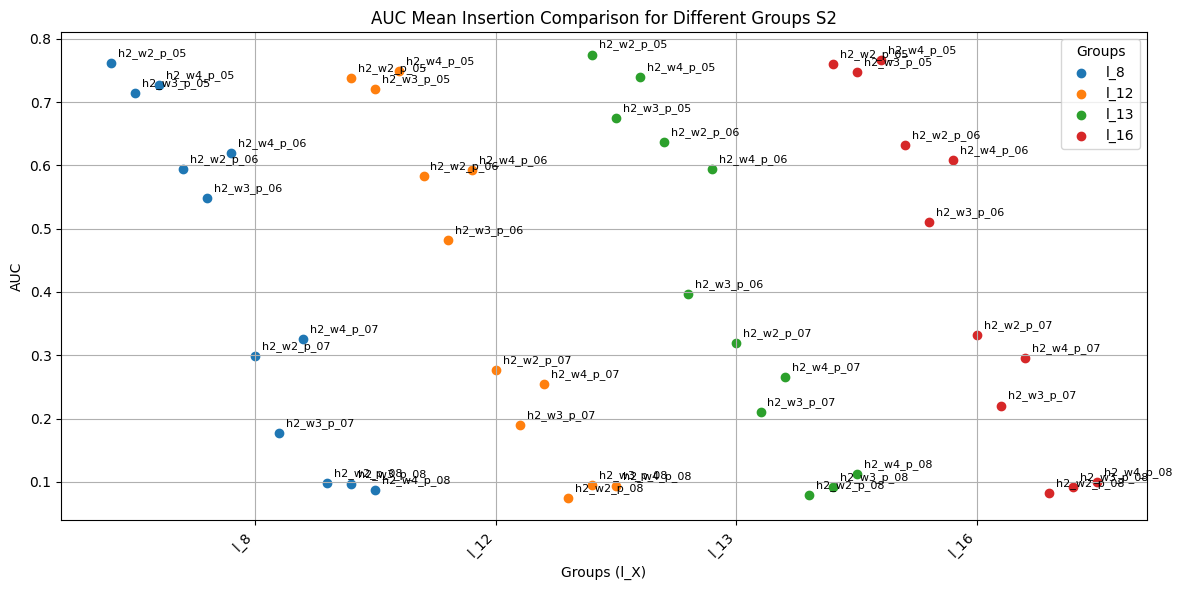

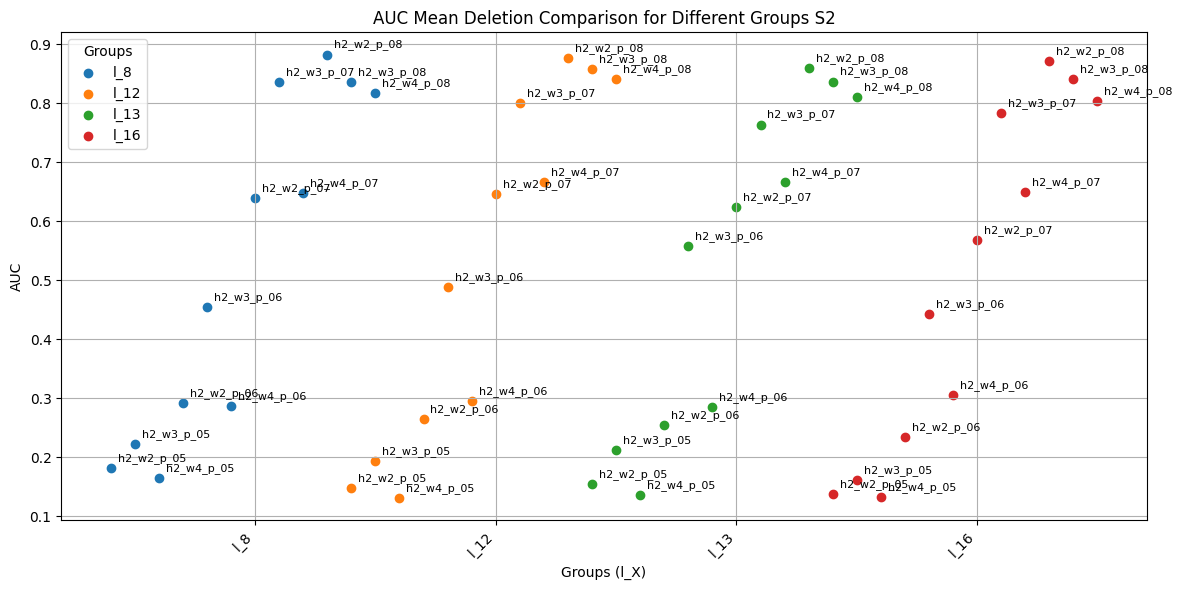

In [7]:
plot_grouped_auc_with_hw(total_auc_insertion_s2_all, title="AUC Mean Insertion Comparison for Different Groups S2")
plot_grouped_auc_with_hw(total_auc_deletion_s2_all, title="AUC Mean Deletion Comparison for Different Groups S2")

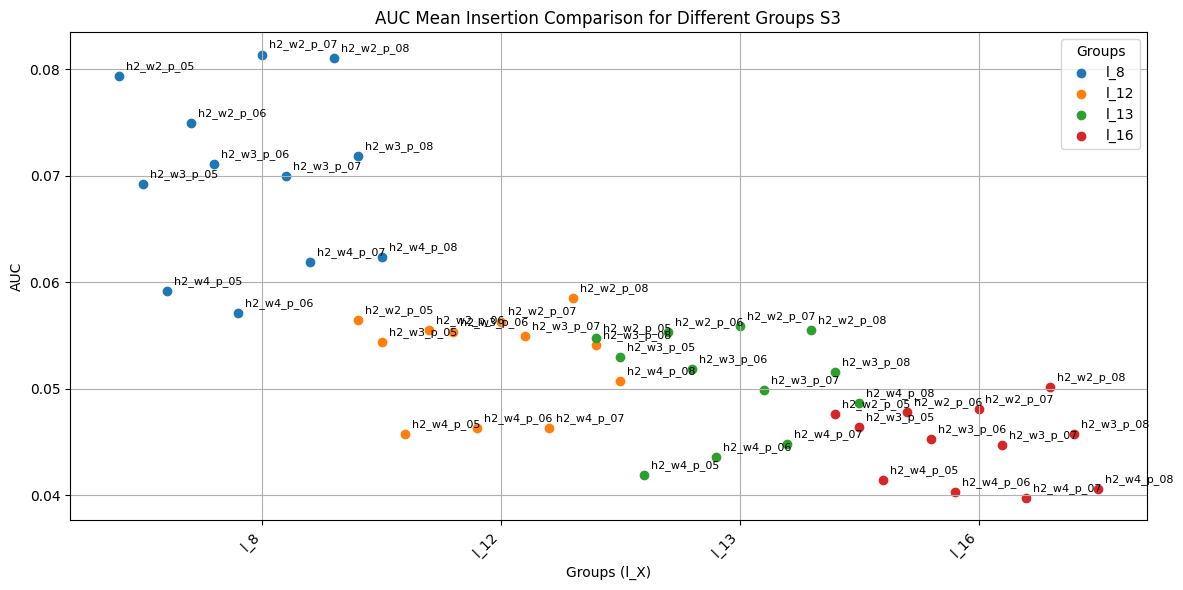

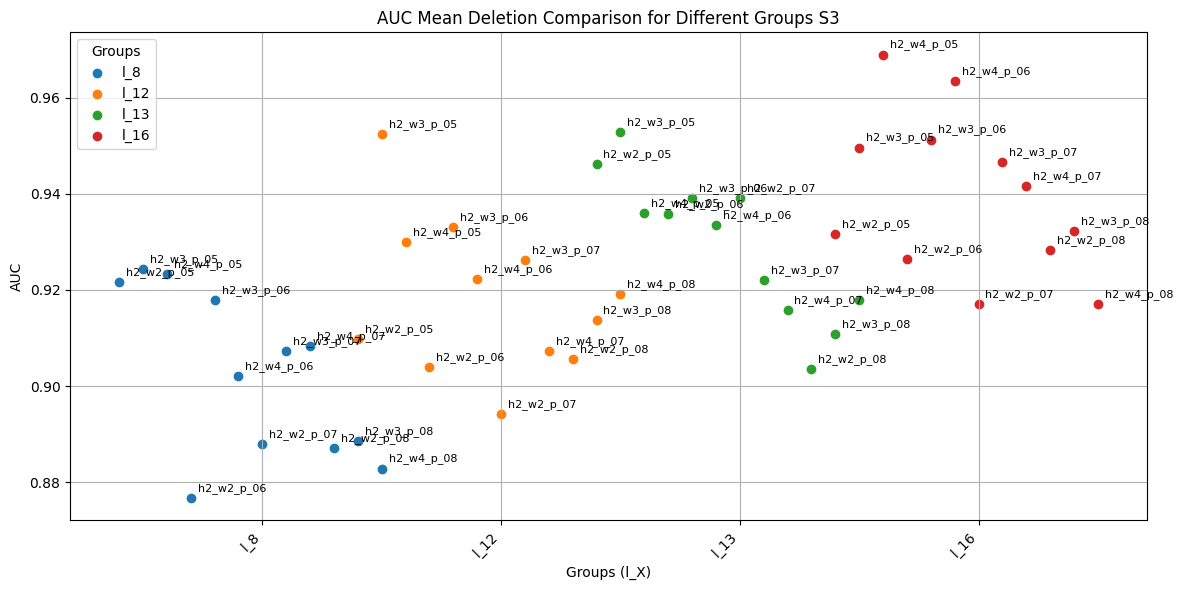

In [8]:
plot_grouped_auc_with_hw(total_auc_insertion_s3_all, title="AUC Mean Insertion Comparison for Different Groups S3")
plot_grouped_auc_with_hw(total_auc_deletion_s3_all, title="AUC Mean Deletion Comparison for Different Groups S3")

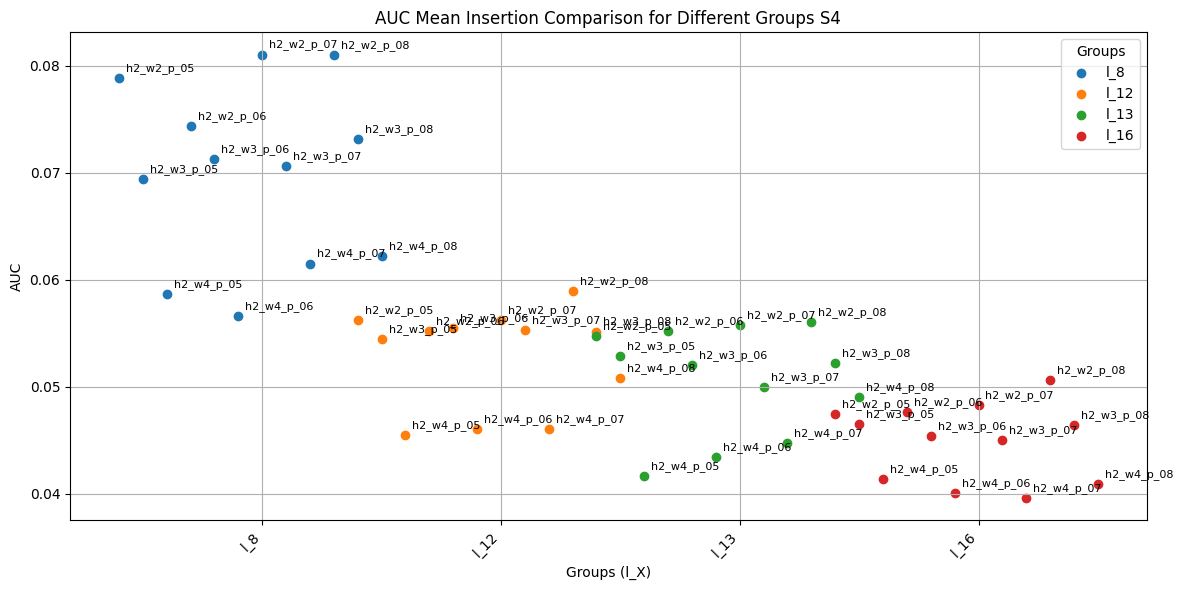

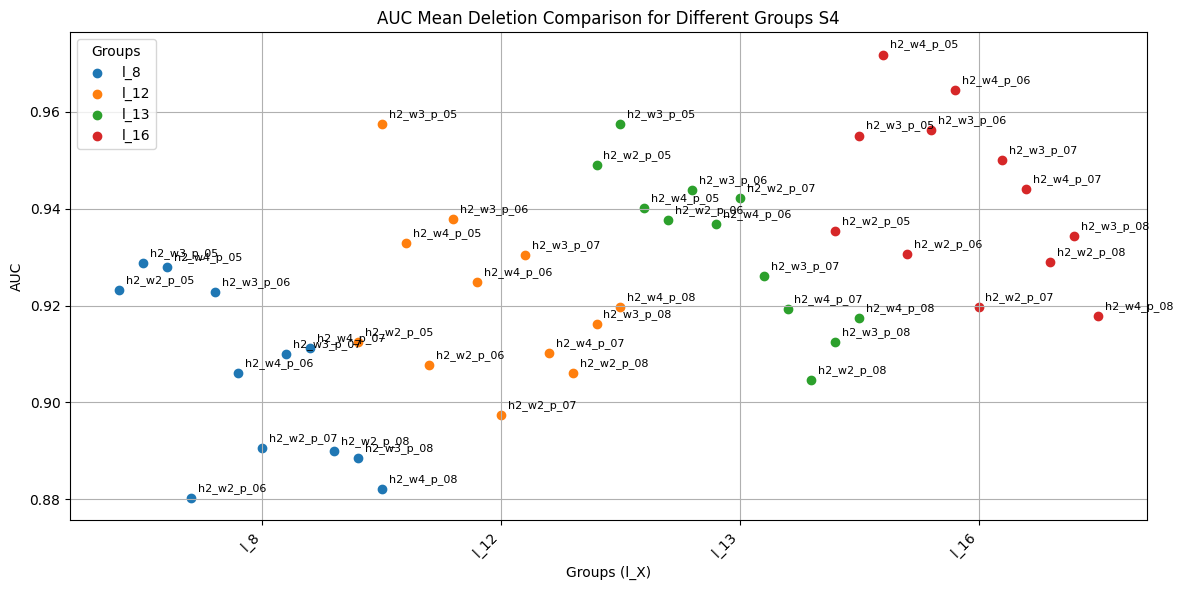

In [9]:
plot_grouped_auc_with_hw(total_auc_insertion_s4_all, title="AUC Mean Insertion Comparison for Different Groups S4")
plot_grouped_auc_with_hw(total_auc_deletion_s4_all, title="AUC Mean Deletion Comparison for Different Groups S4")

In [6]:
path_to_load_results = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial_temporal/results/01_marc_st_rise_total_setups/rise_st_original_result_setup_l_{16}_h{2}_w{4}_p_0{7}.pkl"
            # Load della lista results
with open(path_to_load_results, 'rb') as file:
    result = pickle.load(file)

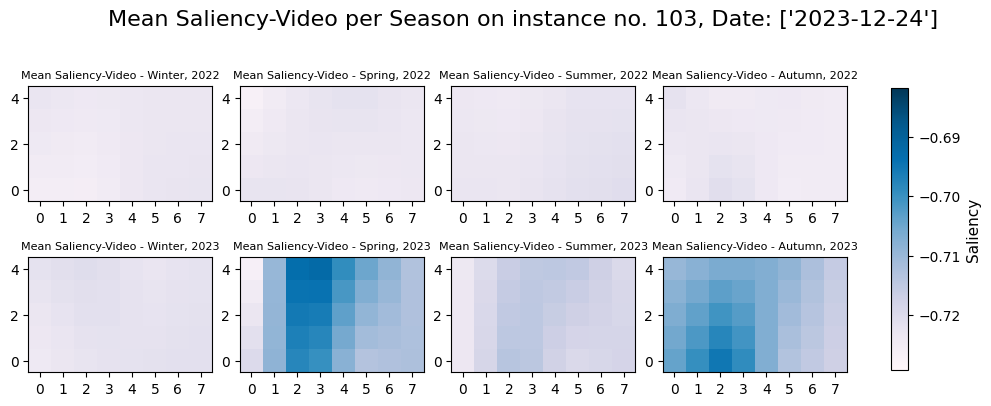

In [7]:
sal_v_s3_0 = result["saliency_videos"][103][2]

plots.plot_sv_mean_per_season(sal_v_s3_0, 103, vottignasco_test_dates, vottignasco_test_image_dates)

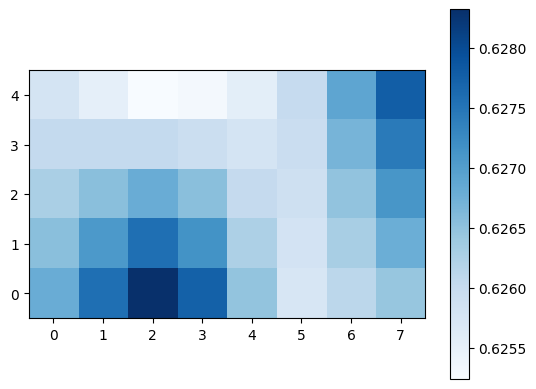

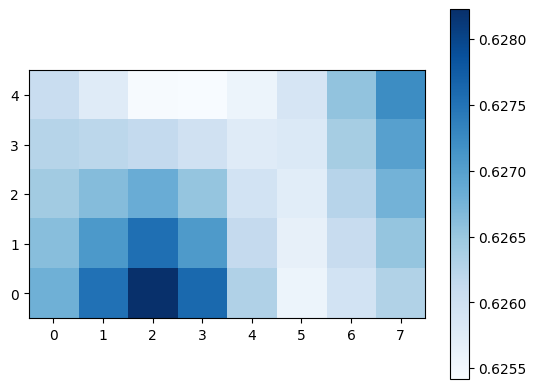

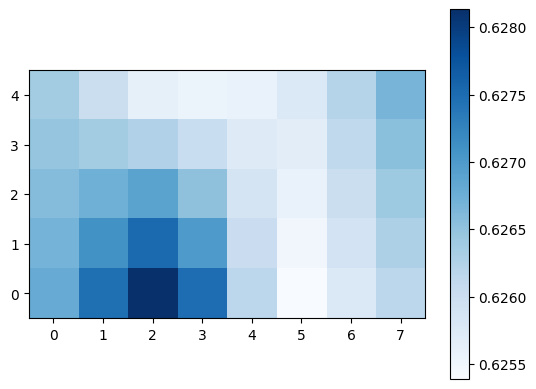

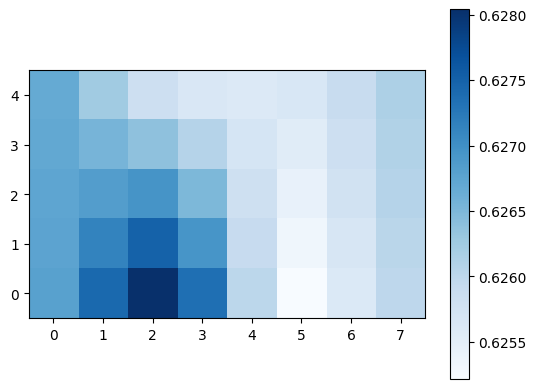

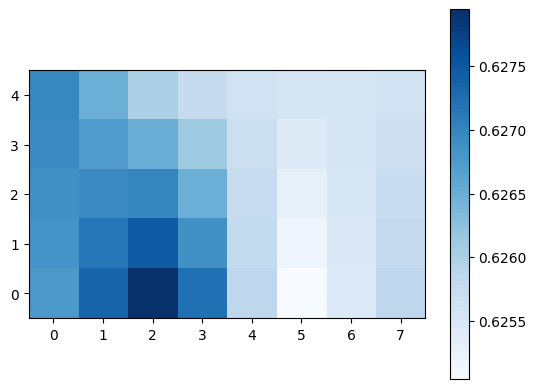

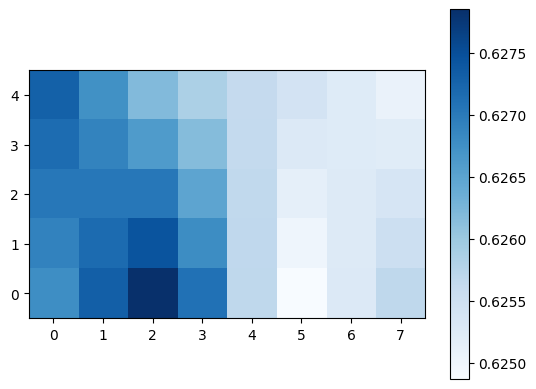

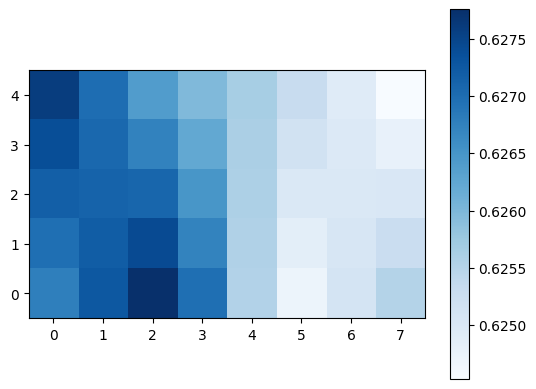

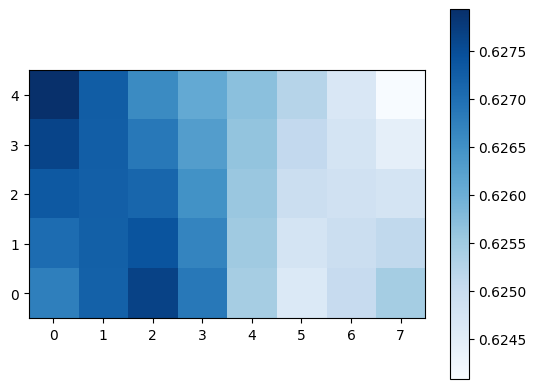

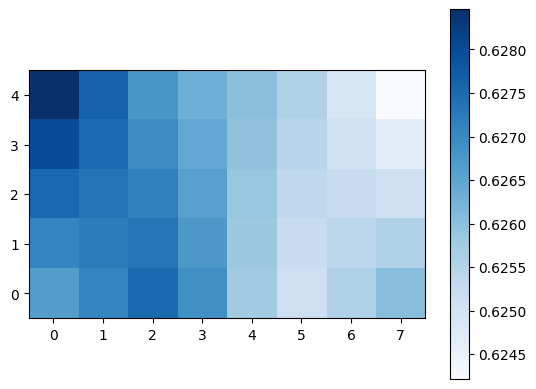

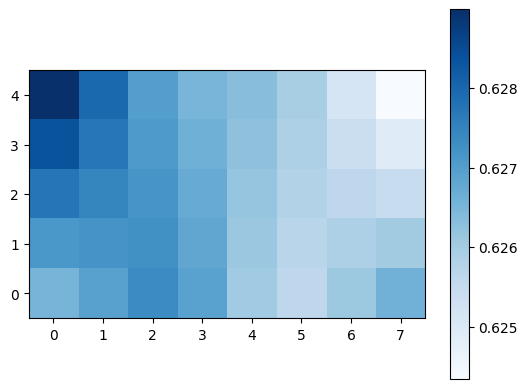

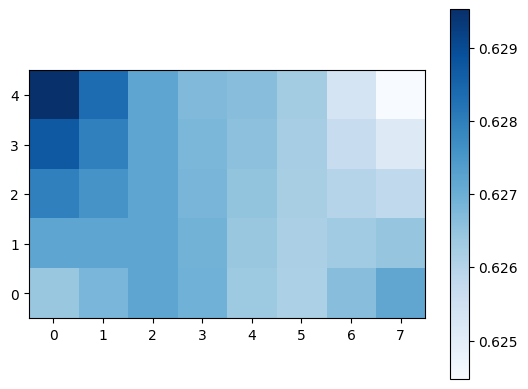

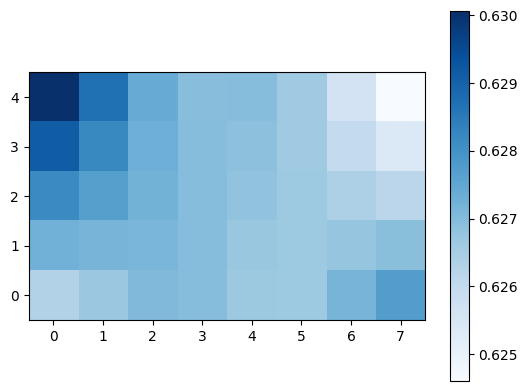

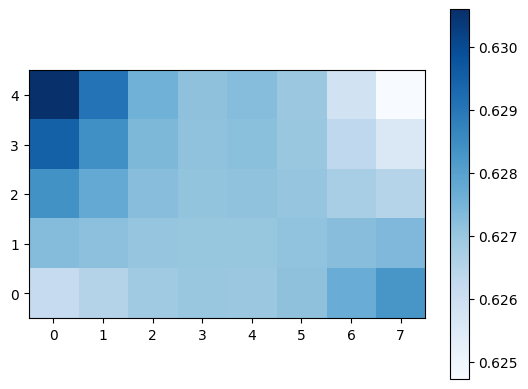

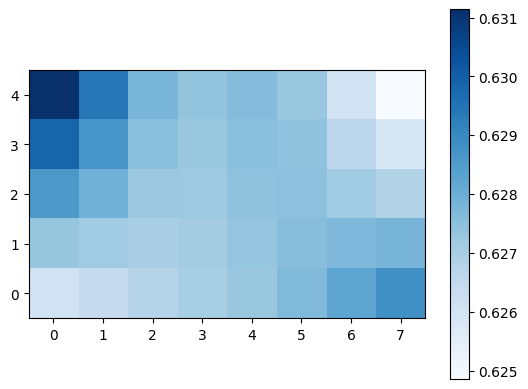

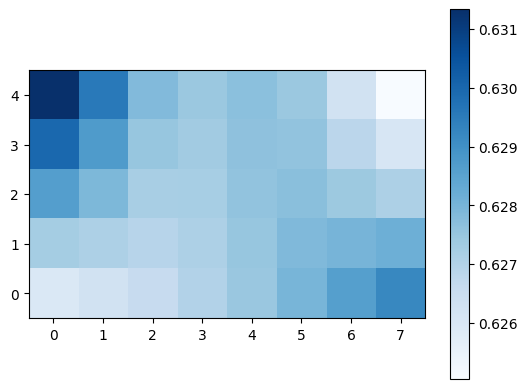

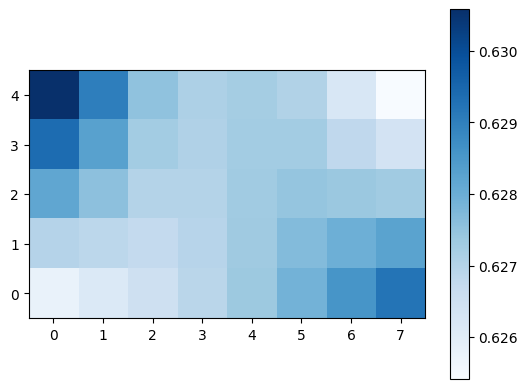

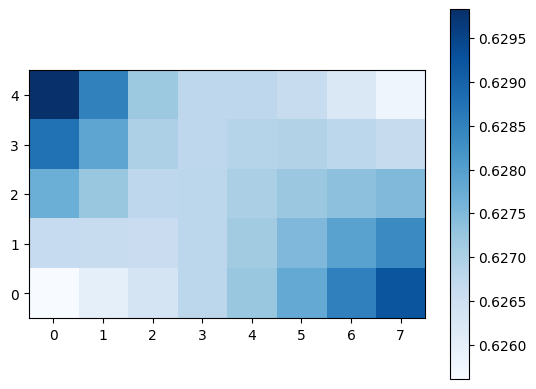

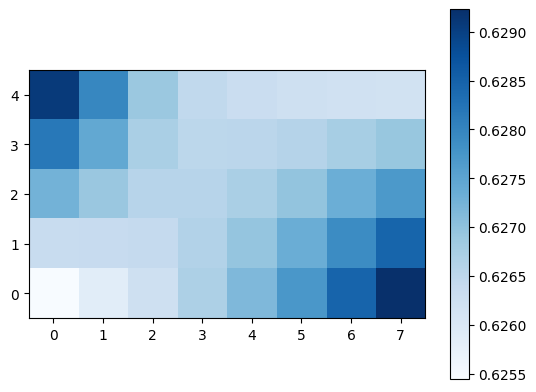

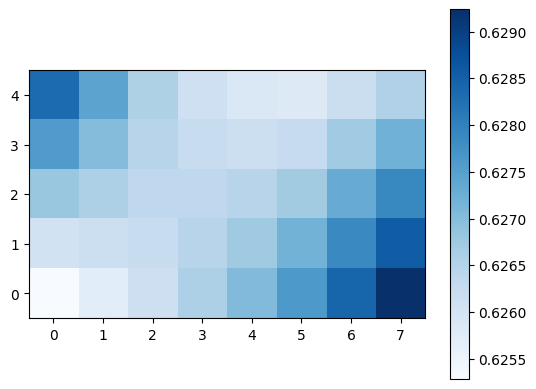

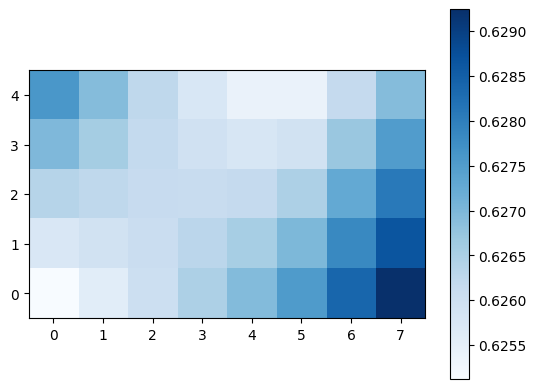

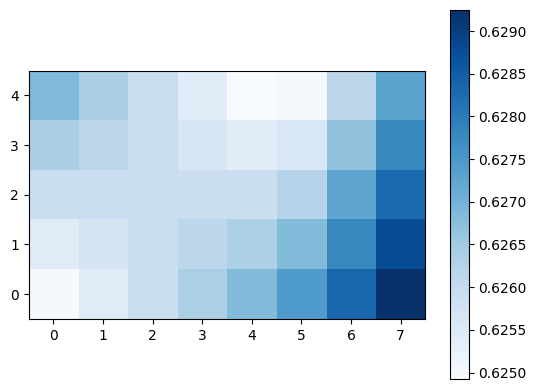

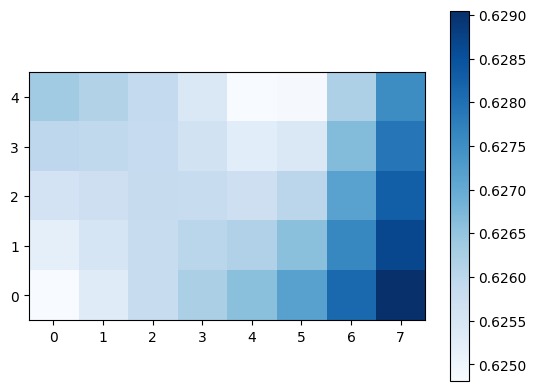

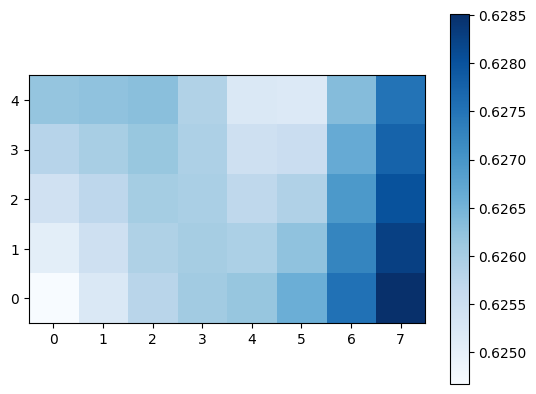

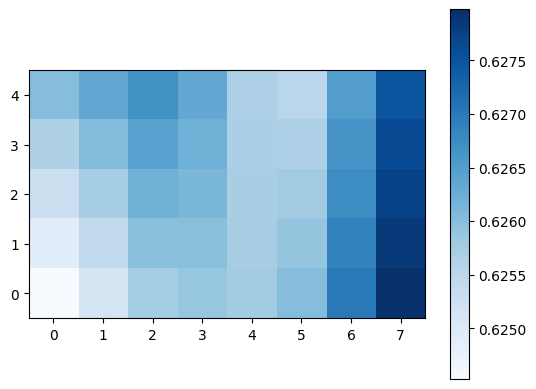

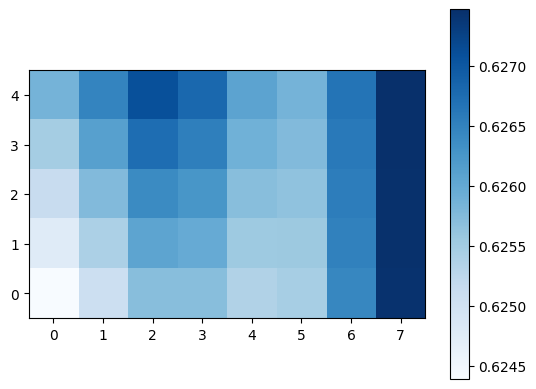

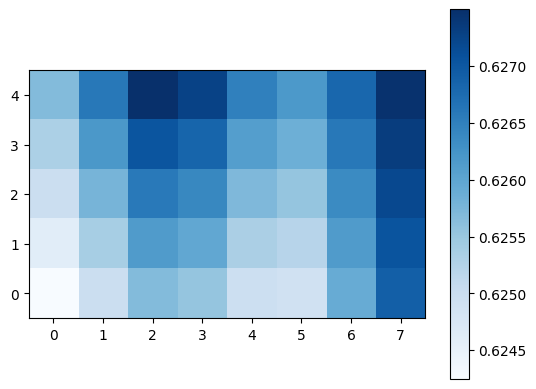

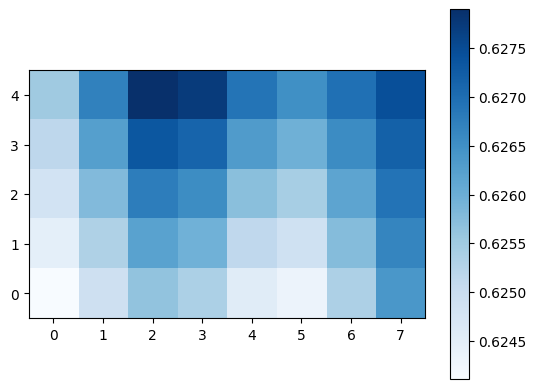

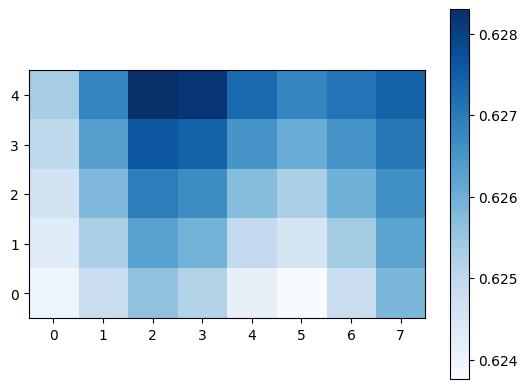

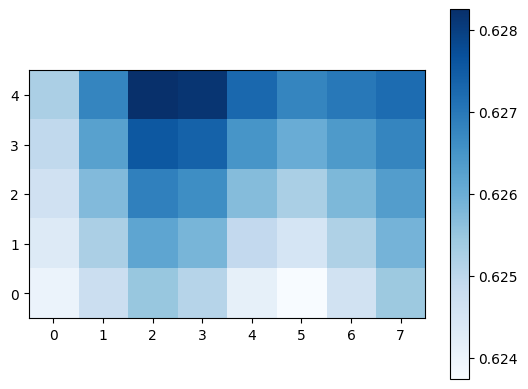

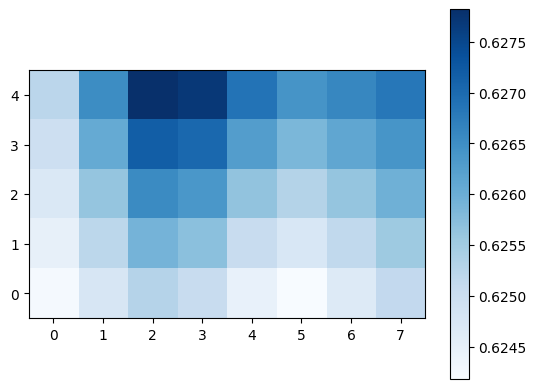

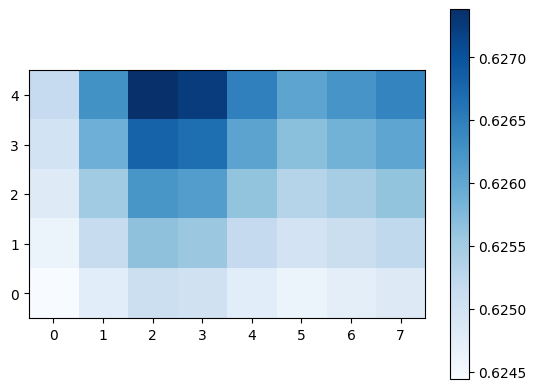

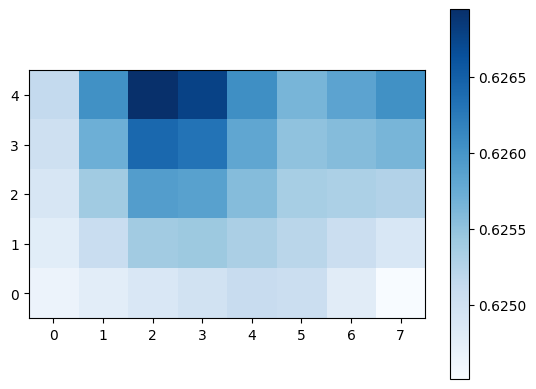

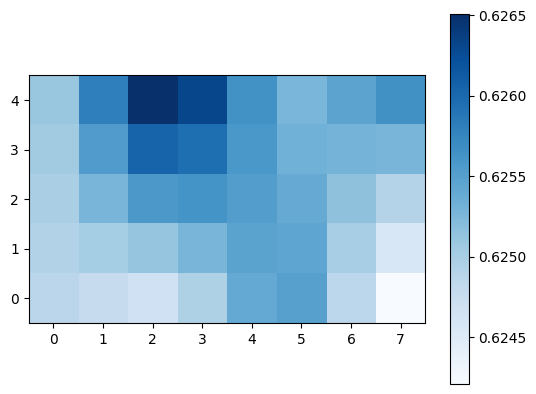

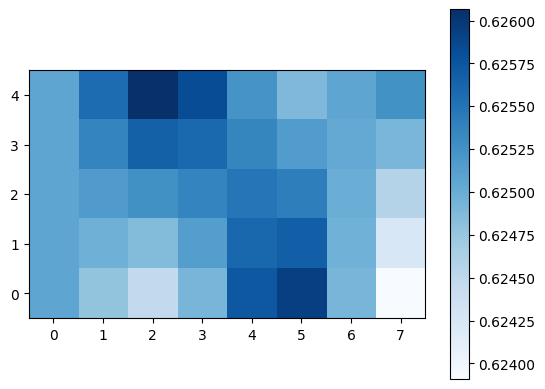

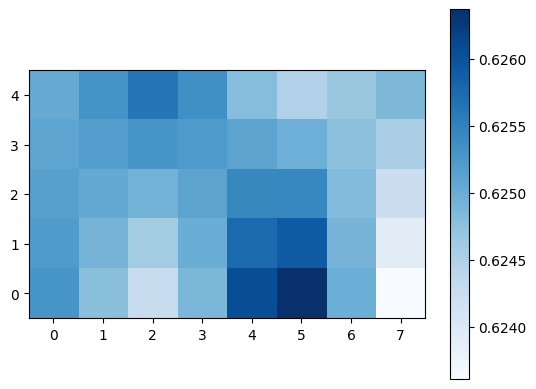

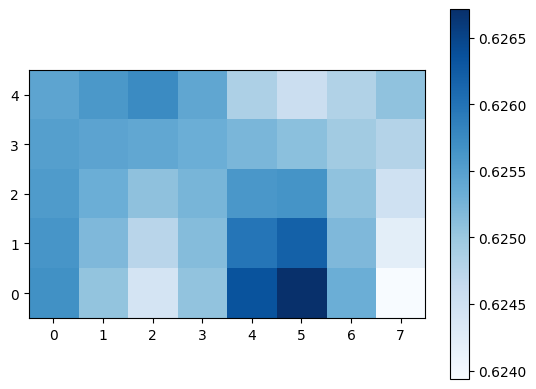

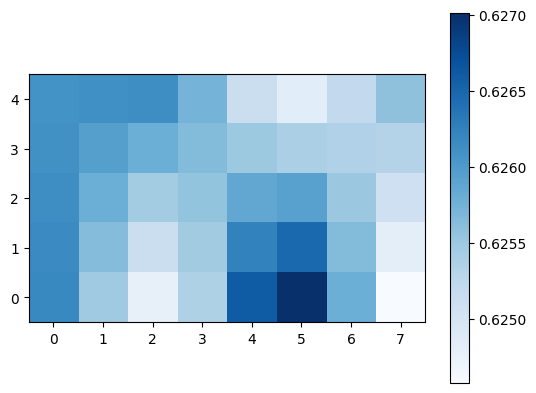

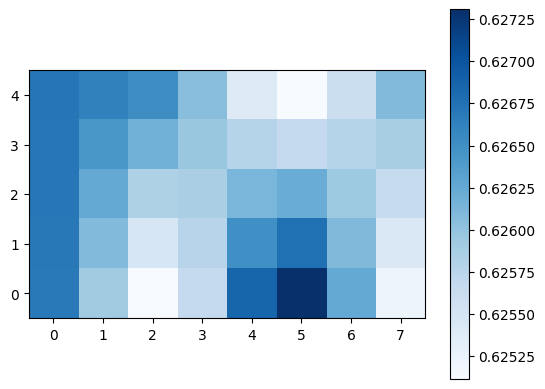

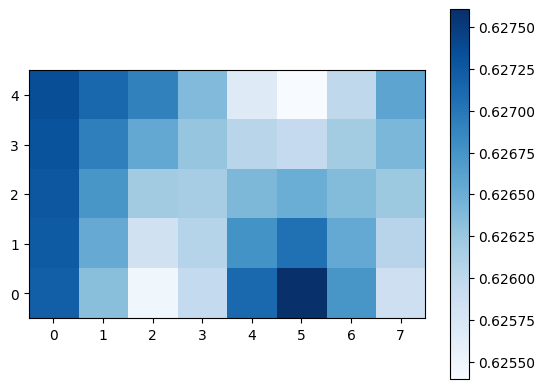

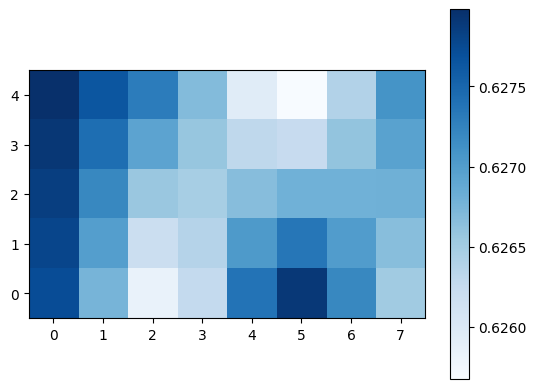

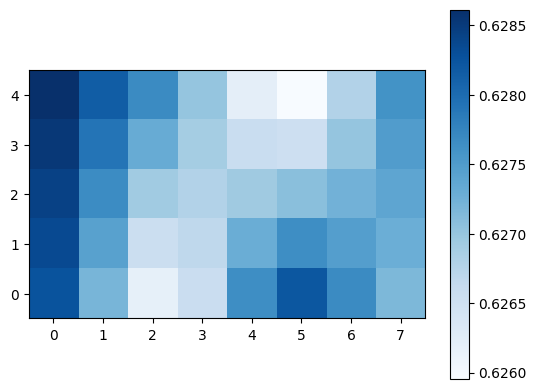

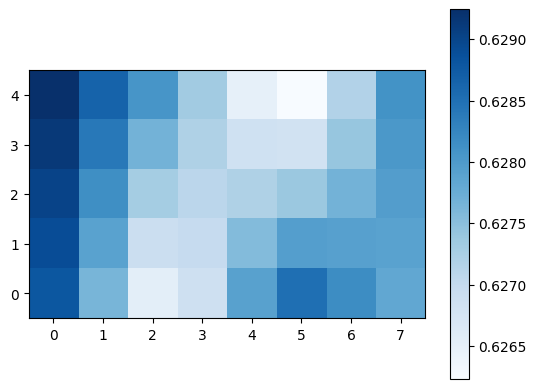

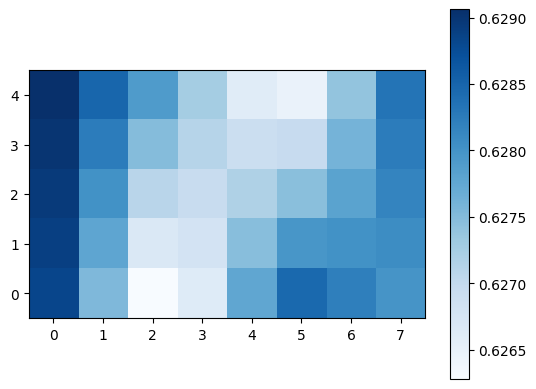

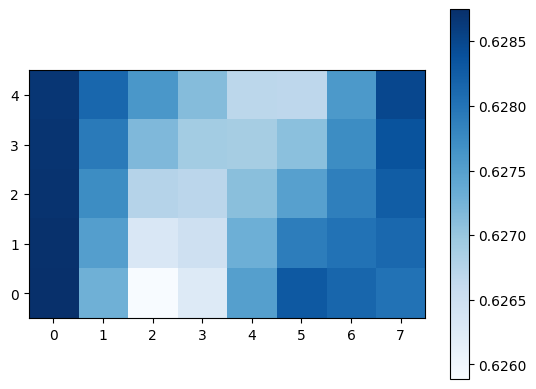

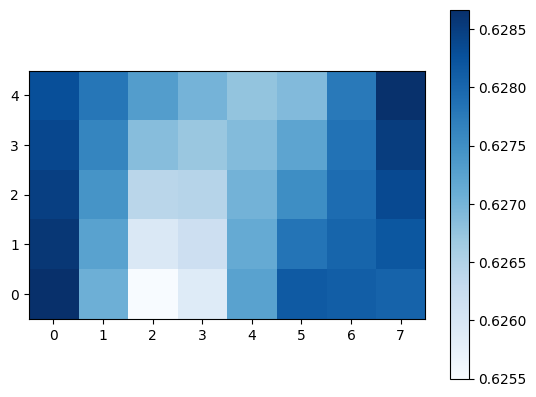

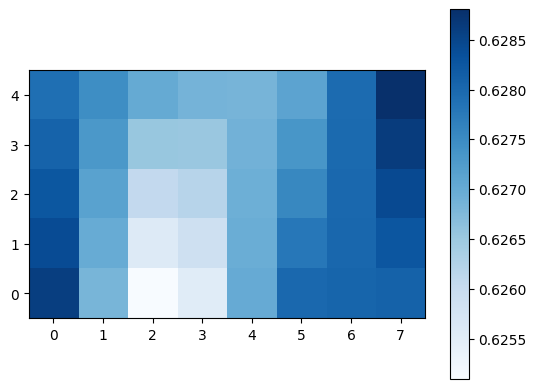

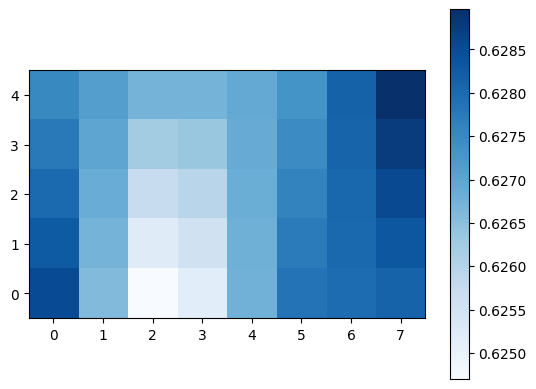

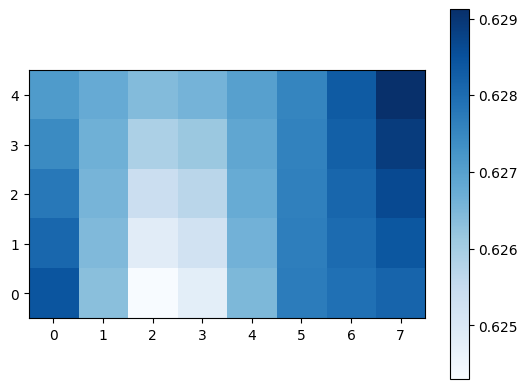

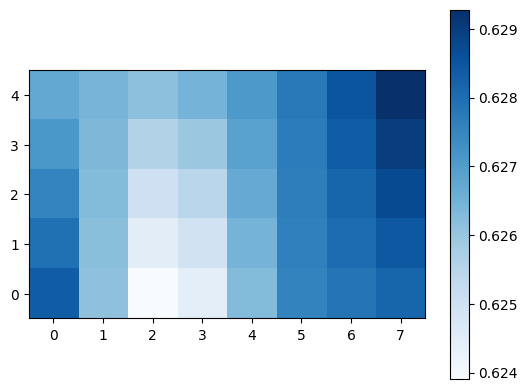

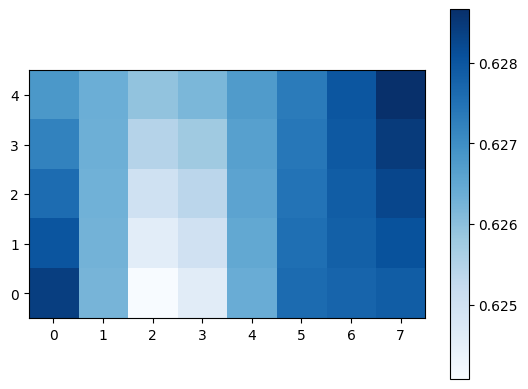

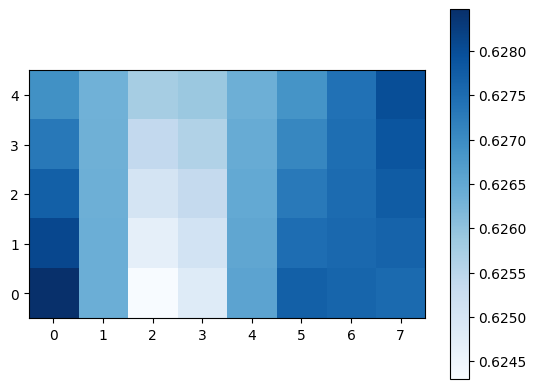

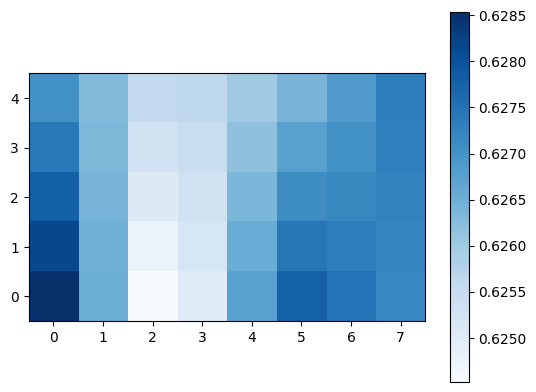

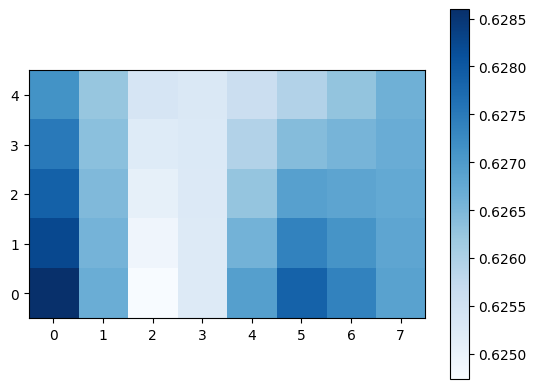

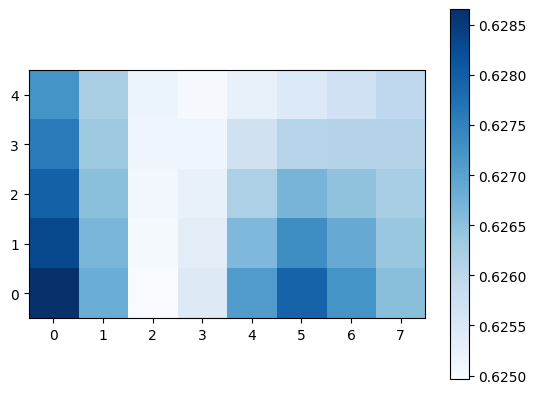

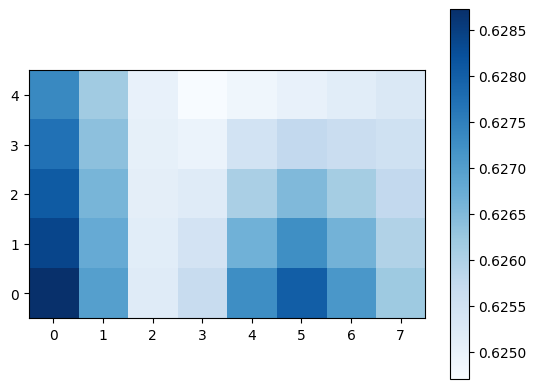

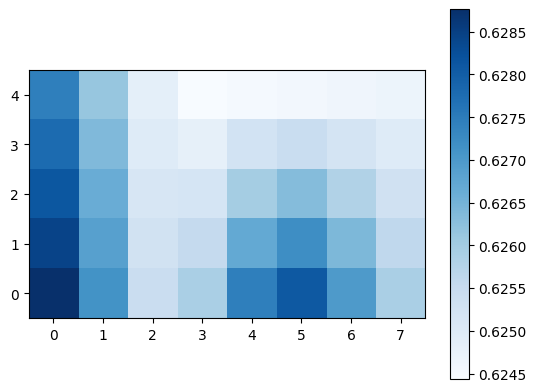

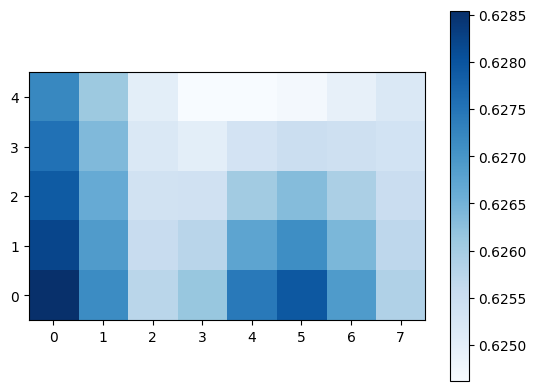

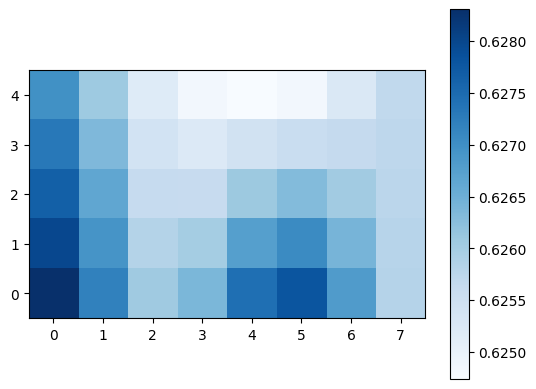

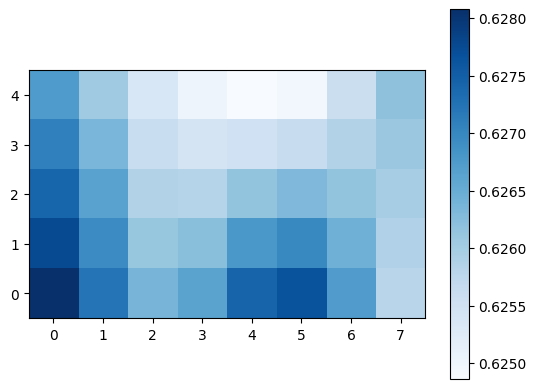

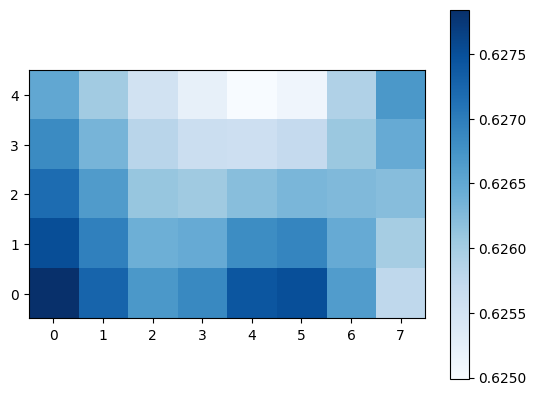

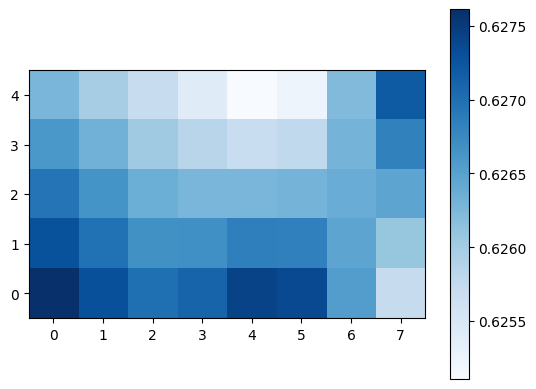

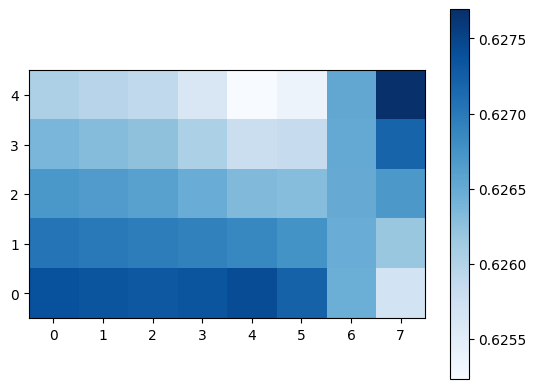

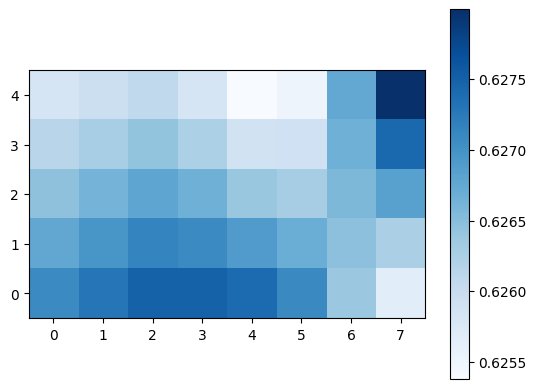

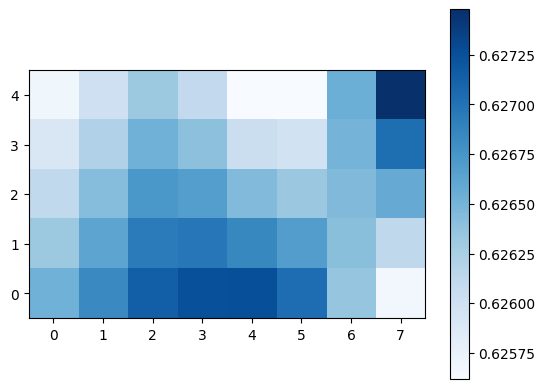

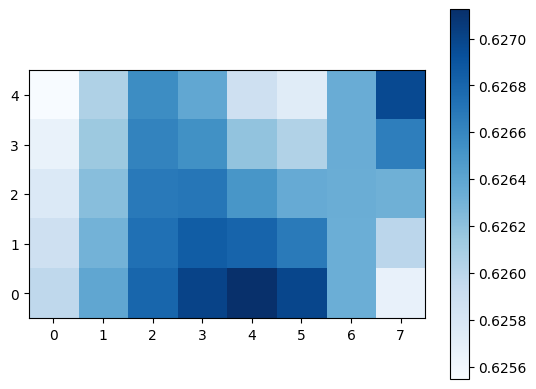

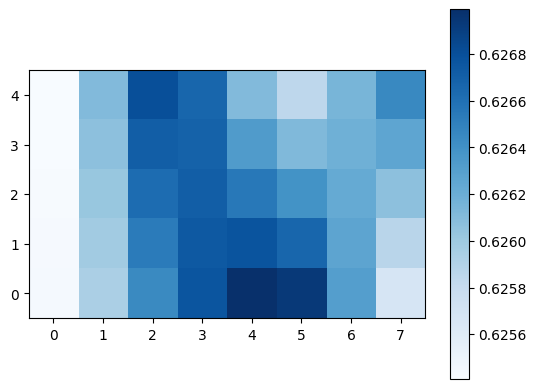

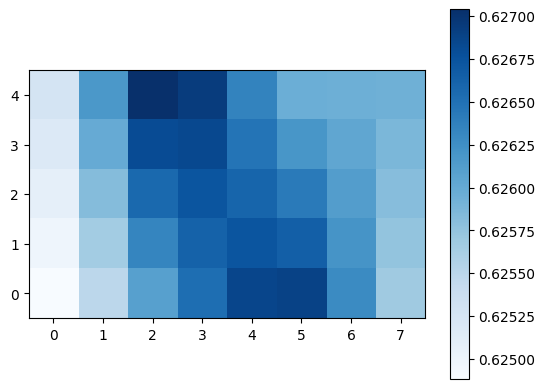

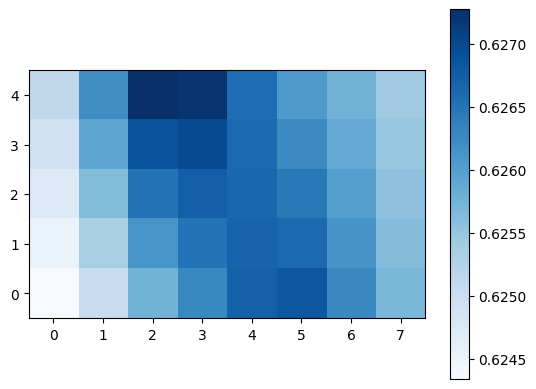

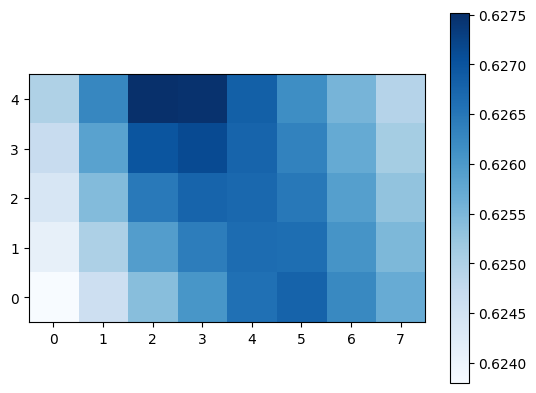

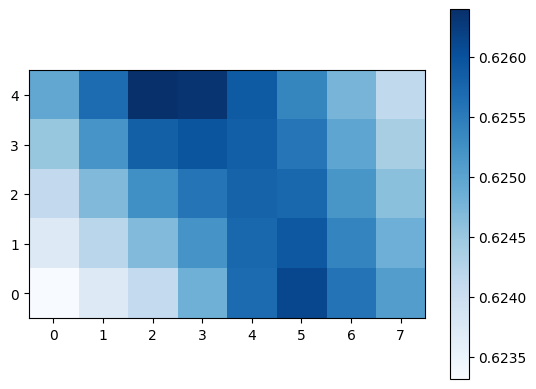

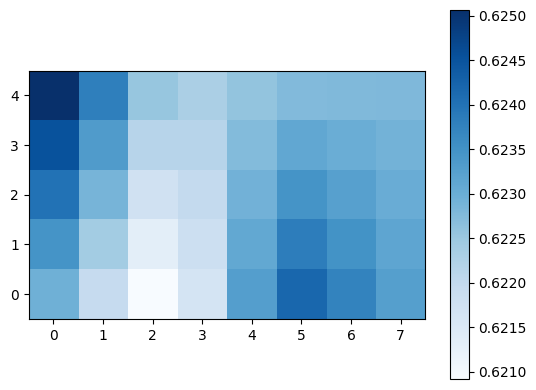

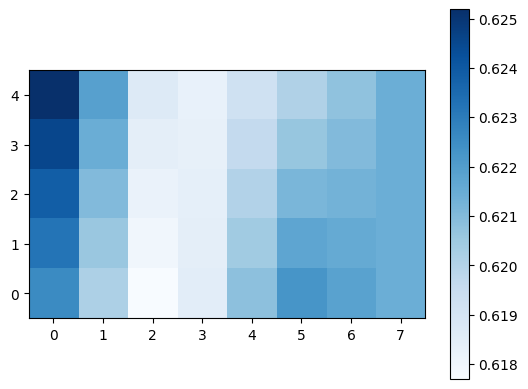

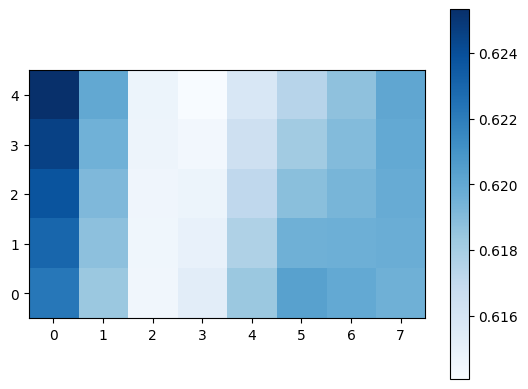

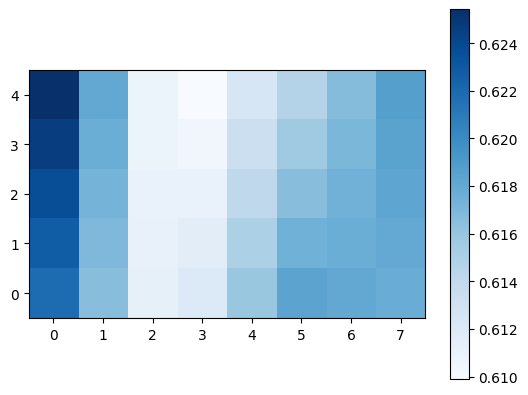

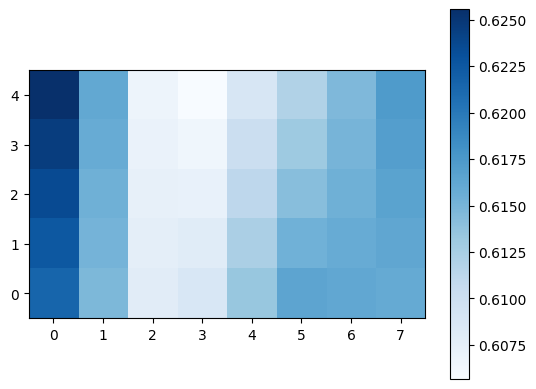

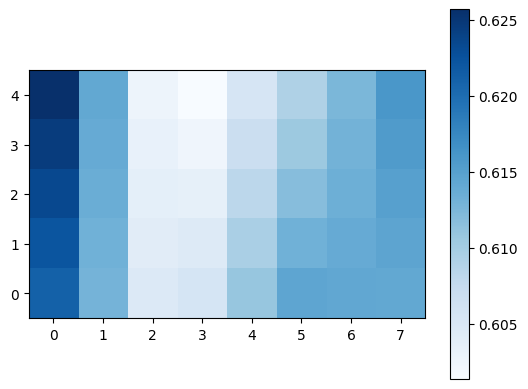

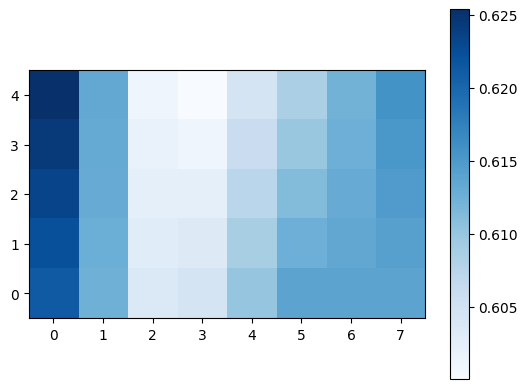

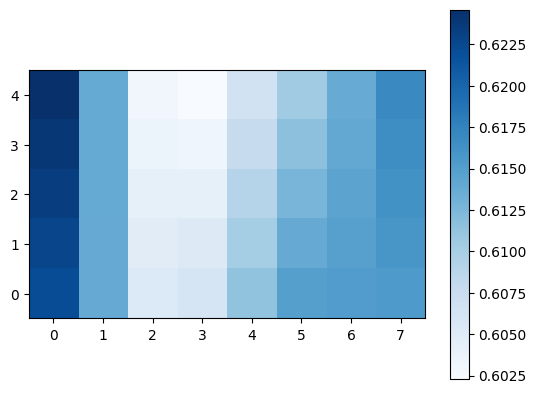

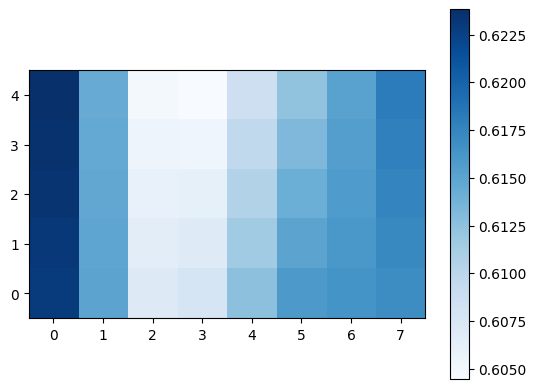

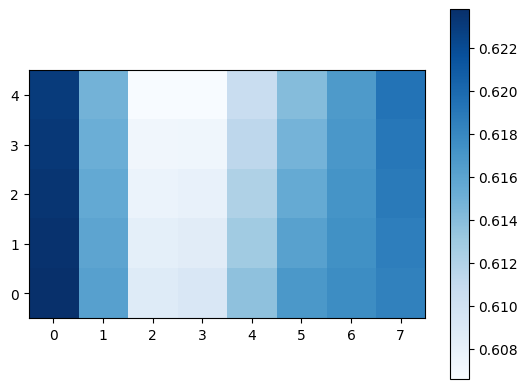

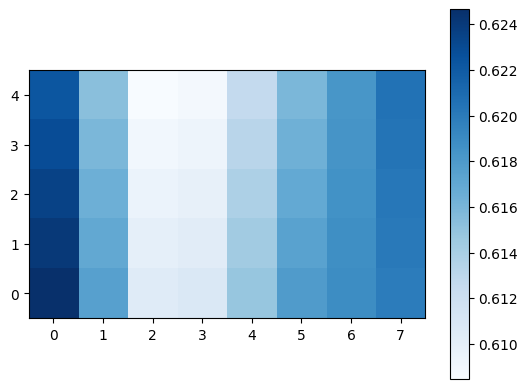

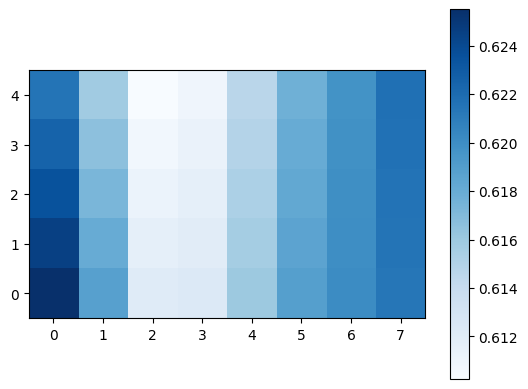

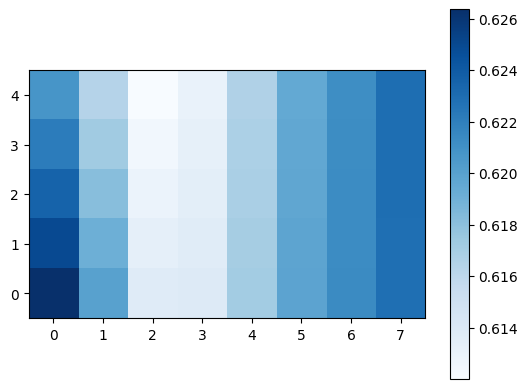

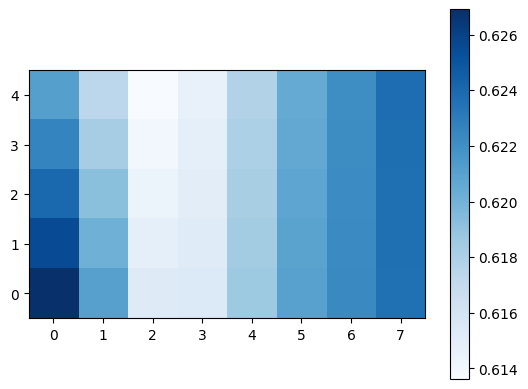

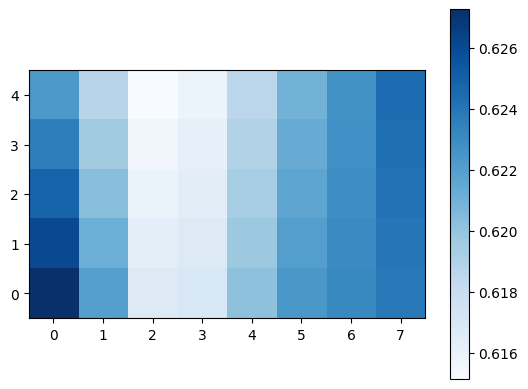

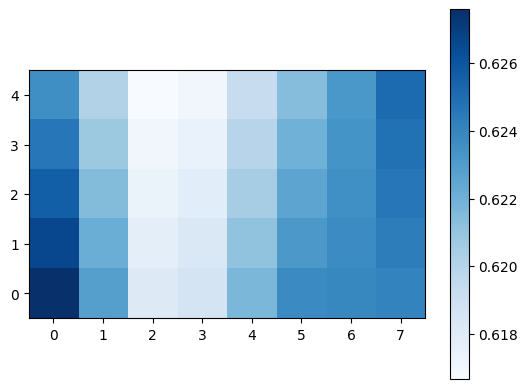

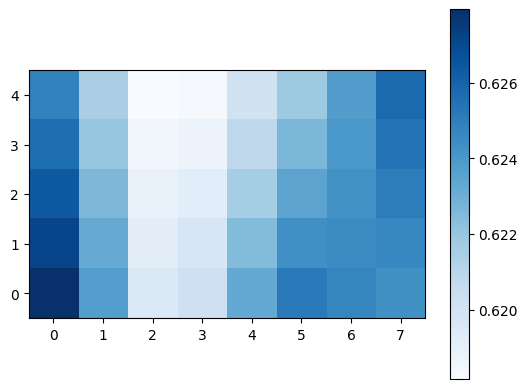

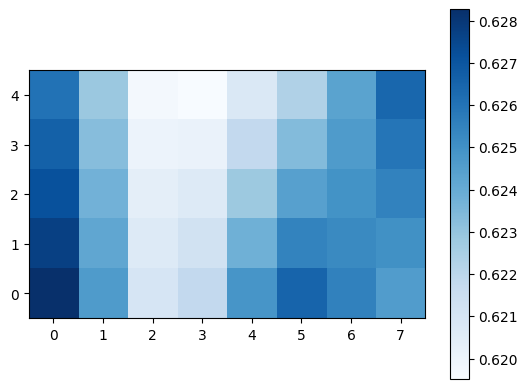

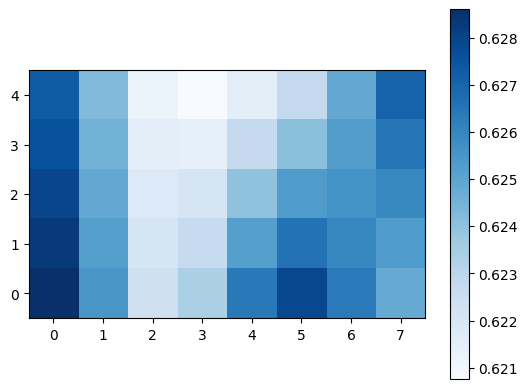

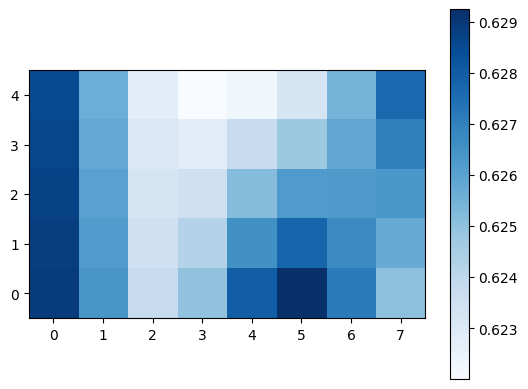

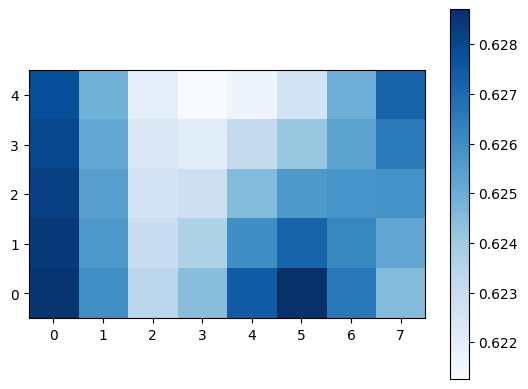

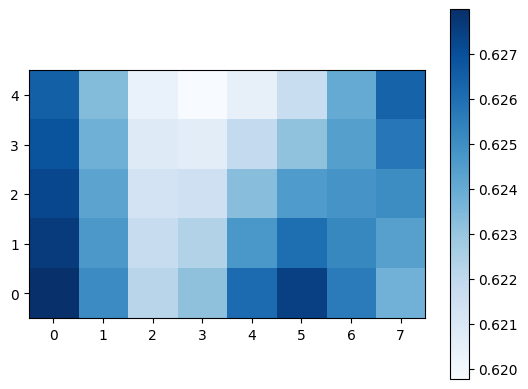

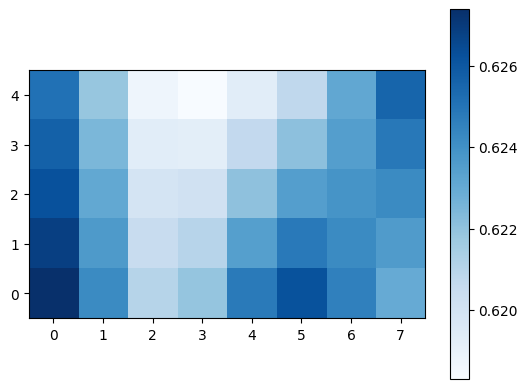

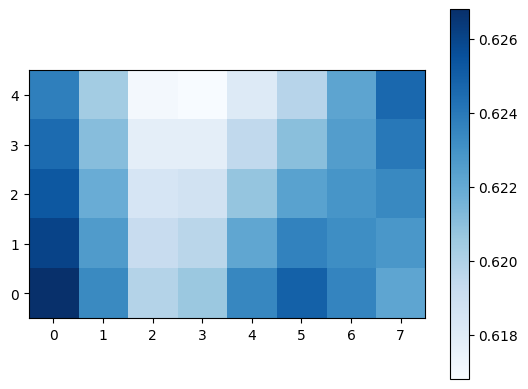

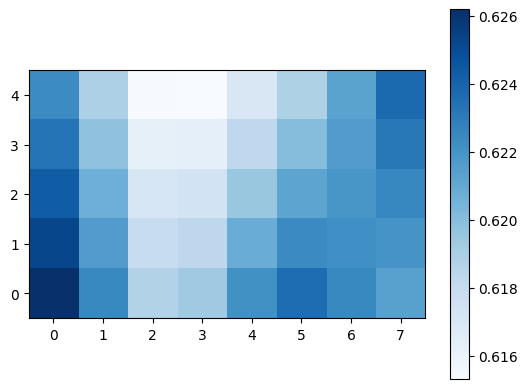

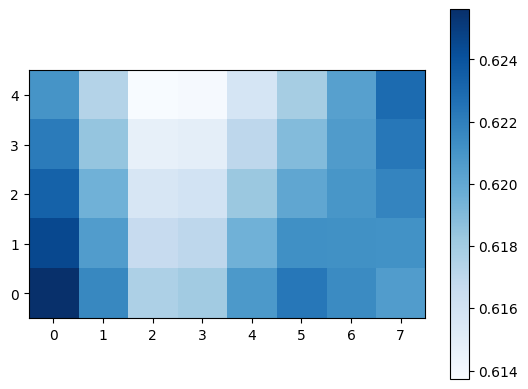

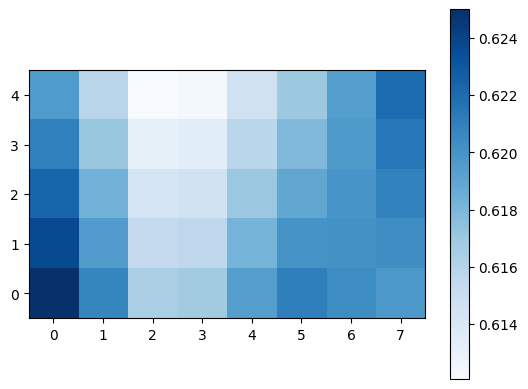

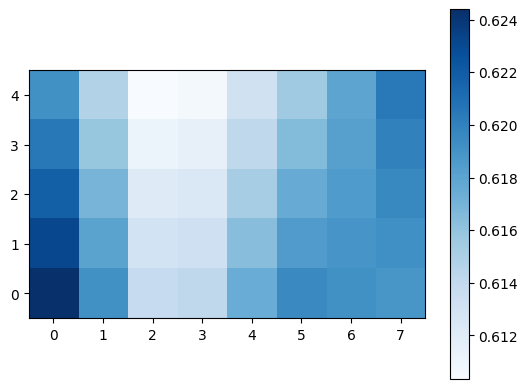

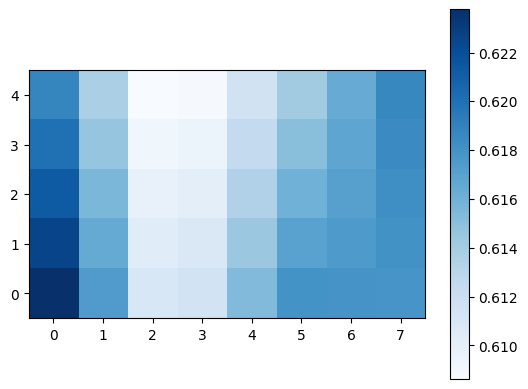

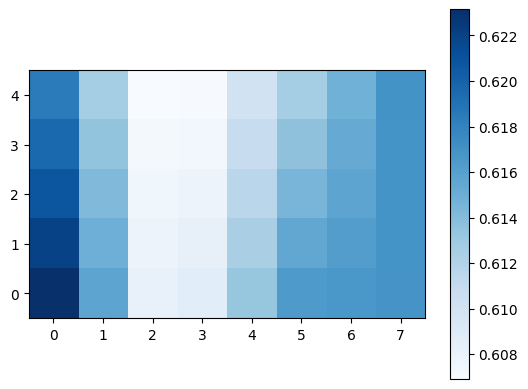

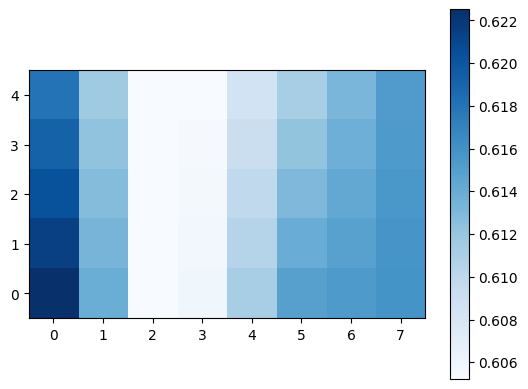

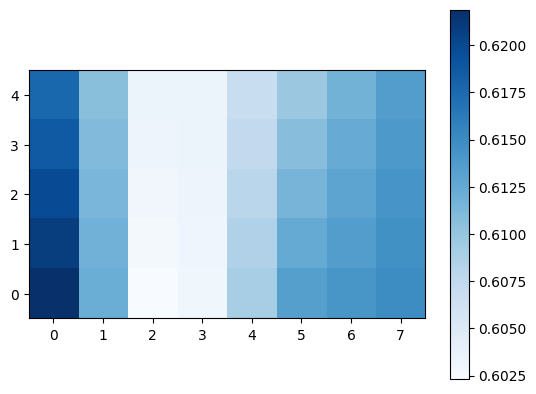

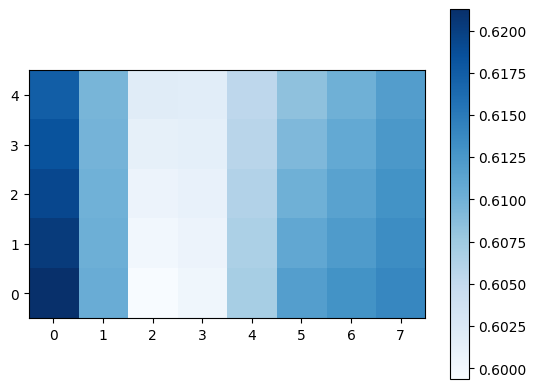

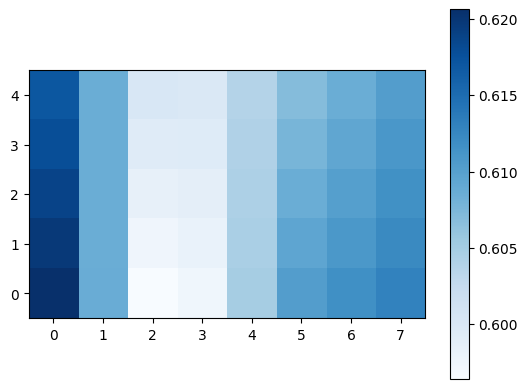

In [22]:
sal_v_s3_0 = result["saliency_videos"][20][3]
for i in range(104):
    plt.imshow(sal_v_s3_0[i], cmap = "Blues", origin = "lower")
    plt.colorbar()
    plt.show()